# Transfer Learning - Concepts and Overview

## 1. What is Transfer Learning?
Transfer Learning is a deep learning technique where a model trained on one task is reused (fully or partially) for a second related task. This is particularly useful when:

- The new dataset is small.
- You want faster development.
- The tasks are similar in nature (e.g., both involve natural images).

**Example:** Using a model trained on ImageNet to classify medical images.

---

## 2. How Transfer Learning Reduces Training Time

- **Shared Representations**: Early layers of deep networks learn low-level features like edges, textures, and colors. These are common across different image tasks.
- **Less Data Needed**: Pretrained models reduce dependence on large datasets.
- **Faster Convergence**: Initial weights are already close to a good solution, requiring fewer training steps.

---

## 3. Pretrained Models

Pretrained models are models trained on large datasets like ImageNet (images) or BooksCorpus (text). These models provide a great foundation for a variety of downstream tasks.

### Examples:

| Model     | Domain | Highlights                                           |
|-----------|--------|------------------------------------------------------|
| VGG       | Image  | Simple deep architecture using 3x3 convolutions     |
| ResNet    | Image  | Introduces residual (skip) connections              |
| Inception | Image  | Uses multi-scale convolutions for efficiency        |
| EfficientNet | Image | Scales depth, width, and resolution uniformly     |
| BERT      | Text   | Pretrained bidirectional transformer for NLP        |
| GPT       | Text   | Causal transformer pretrained using language modeling |

---

## 4. Fine-Tuning vs. Feature Extraction

| Aspect         | Fine-Tuning                                  | Feature Extraction                            |
|----------------|-----------------------------------------------|------------------------------------------------|
| Layers Trained | All or some layers + new classifier           | Only the new classifier layer                 |
| Flexibility    | High – can adapt to complex tasks             | Low – assumes pretrained features are enough  |
| Training Time  | More training time                            | Less training time                            |
| Use Case       | Large or complex dataset, task-specific       | Small dataset, generic tasks                  |

---

## Summary
Transfer learning saves time and resources while maintaining high performance, especially on smaller datasets. It is now a default choice in many computer vision and NLP workflows.


# Case Study 1: Feature Extraction using Pretrained VGG16



We will classify images of cats and dogs using a pretrained VGG16 model as a feature extractor.

## Dataset
We will use TensorFlow's `cats_vs_dogs` dataset.

## Steps:
- Load the dataset
- Preprocess images
- Use VGG16 for feature extraction (with `include_top=False`)
- Train a simple dense classifier on top


![VGG16](https://storage.googleapis.com/lds-media/images/vgg16-architecture.width-1200.jpg)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import get_file, image_dataset_from_directory

# Download and extract the dataset
zip_path = get_file(
    fname='cats_and_dogs_filtered.zip',
    origin='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
    extract=True
)

# Extracted directory path
data_dir = "/root/.keras/datasets/cats_and_dogs_filtered_extracted/cats_and_dogs_filtered"

# Subdirectories
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/validation"

# Load datasets
train_ds = image_dataset_from_directory(train_dir, image_size=(160, 160), batch_size=32)
val_ds = image_dataset_from_directory(val_dir, image_size=(160, 160), batch_size=32)

class_names = train_ds.class_names

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# Normalize images
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# Load pretrained VGG16
base_model = VGG16(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

In [ ]:
# Create model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile and train
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.6470 - loss: 0.6172 - val_accuracy: 0.8130 - val_loss: 0.4250
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.8447 - loss: 0.3823 - val_accuracy: 0.8590 - val_loss: 0.3326
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.8916 - loss: 0.3093 - val_accuracy: 0.8680 - val_loss: 0.2968
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8941 - loss: 0.2651 - val_accuracy: 0.8720 - val_loss: 0.2743
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9007 - loss: 0.2521 - val_accuracy: 0.8810 - val_loss: 0.2669


## Evaluation & Visualization

We’ll evaluate the model on the validation set and show some:
- Correct predictions
- Incorrect predictions


In [ ]:
# Evaluate model
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8775 - loss: 0.2585
Validation Accuracy: 0.8810


In [ ]:
# Collect some predictions
image_batch, label_batch = next(iter(val_ds.unbatch().batch(32)))
predictions = model.predict(image_batch)
pred_labels = (predictions > 0.5).astype("int").flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


In [ ]:
def show_images(images, labels, preds, correct=True, max_images=6):
    count = 0
    plt.figure(figsize=(15, 8))
    for i in range(len(images)):
        if (preds[i] == labels[i]) == correct:
            ax = plt.subplot(2, 3, count + 1)

            # Undo normalization: rescale 0–1 to 0–255
            img = images[i].numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")

            plt.imshow(img)
            color = "green" if correct else "red"
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}", color=color)
            plt.axis("off")
            count += 1
        if count == max_images:
            break
    plt.suptitle("Correct Predictions" if correct else "Incorrect Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

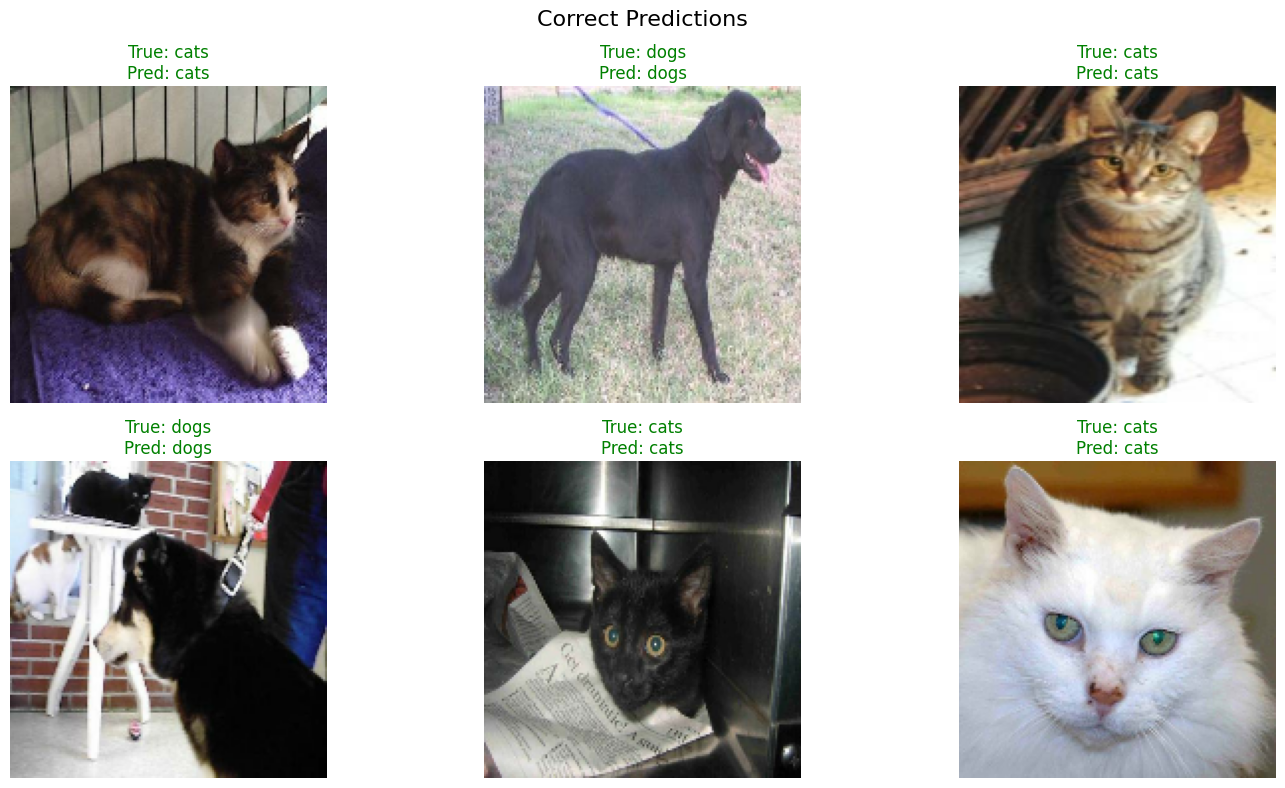

In [ ]:
# Show correct predictions
show_images(image_batch, label_batch.numpy().astype(int), pred_labels, correct=True)

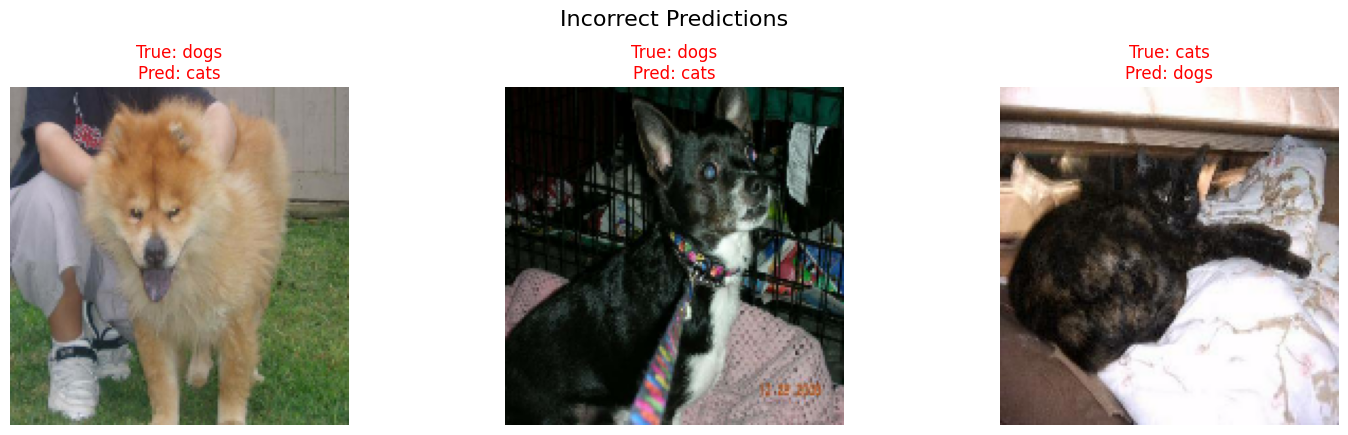

In [ ]:
# Show incorrect predictions
show_images(image_batch, label_batch.numpy().astype(int), pred_labels, correct=False)

# Case Study 2: Fine-Tuning with ResNet50

We now unfreeze the top layers of a pretrained ResNet50 and fine-tune it for our dataset.

## Scenario
You already did feature extraction, but want better performance or you're working with a more complex dataset.

## Steps:
- Load pretrained model
- Freeze base, then unfreeze some top layers
- Retrain with a low learning rate

![ResNet50](https://towardsdatascience.com/wp-content/uploads/2022/08/0tH9evuOFqk8F41FG.png)

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load model with pretrained weights
base_model = ResNet50(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Now we’ll fine-tune

# Freeze all layers except the top 50%
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Build new model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile with low LR
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 447ms/step - accuracy: 0.5744 - loss: 0.6957 - val_accuracy: 0.5000 - val_loss: 0.7049
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.7829 - loss: 0.5032 - val_accuracy: 0.4990 - val_loss: 0.8909
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.8714 - loss: 0.3645 - val_accuracy: 0.4990 - val_loss: 1.0690
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9111 - loss: 0.2711 - val_accuracy: 0.5080 - val_loss: 0.9249
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9545 - loss: 0.1761 - val_accuracy: 0.5500 - val_loss: 0.9085


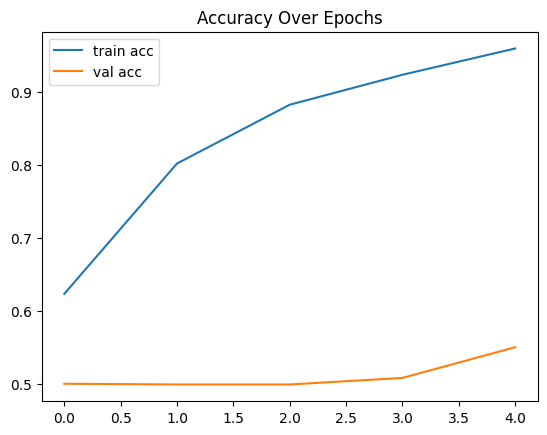

In [ ]:
# Accuracy curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy Over Epochs')
plt.legend()
#plt.show()

## Evaluation & Visualization
After fine-tuning, we’ll:
- Evaluate the model
- Display some correctly and incorrectly predicted images


In [ ]:
# Evaluate
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy after Fine-Tuning: {acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5284 - loss: 0.9527
Validation Accuracy after Fine-Tuning: 0.5500


In [ ]:
# Get predictions
image_batch, label_batch = next(iter(val_ds.unbatch().batch(32)))
predictions = model.predict(image_batch)
pred_labels = (predictions > 0.5).astype("int").flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


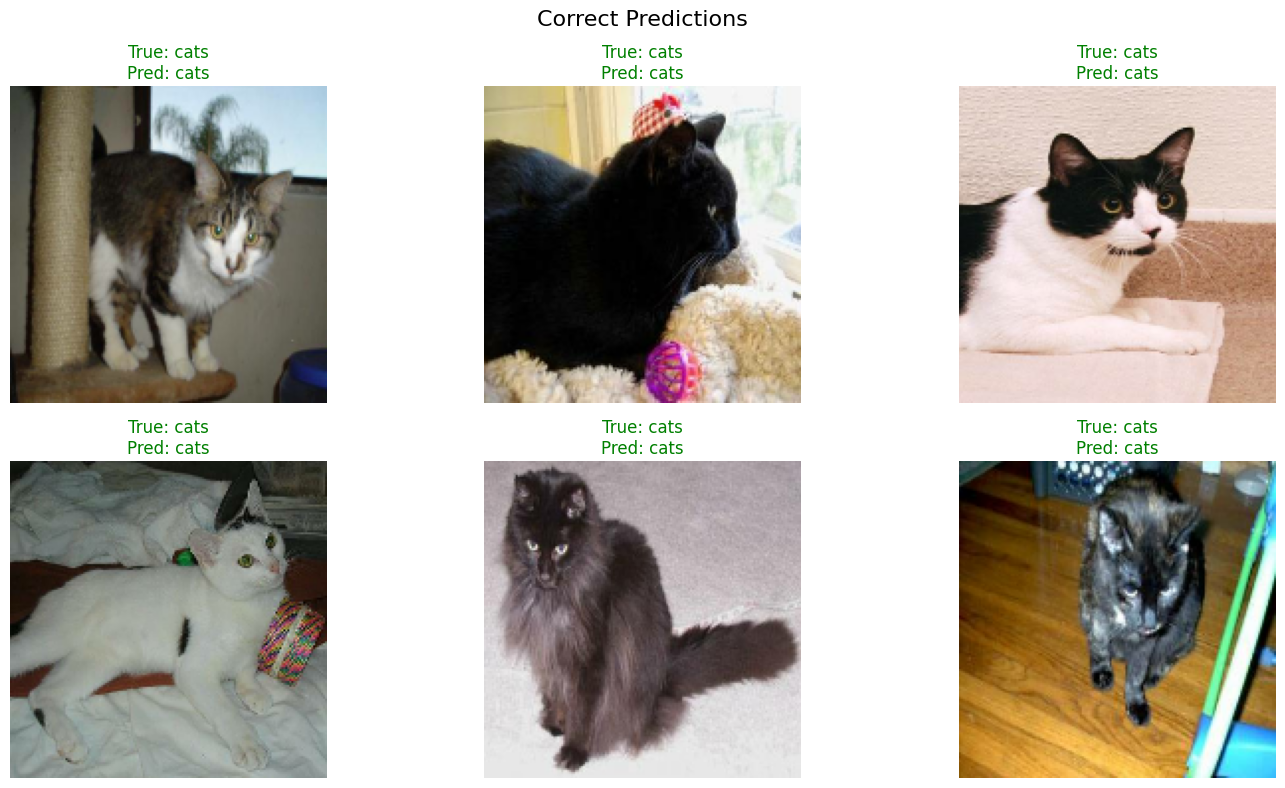

In [ ]:
# Reuse the same visualization function
show_images(image_batch, label_batch.numpy().astype(int), pred_labels, correct=True)

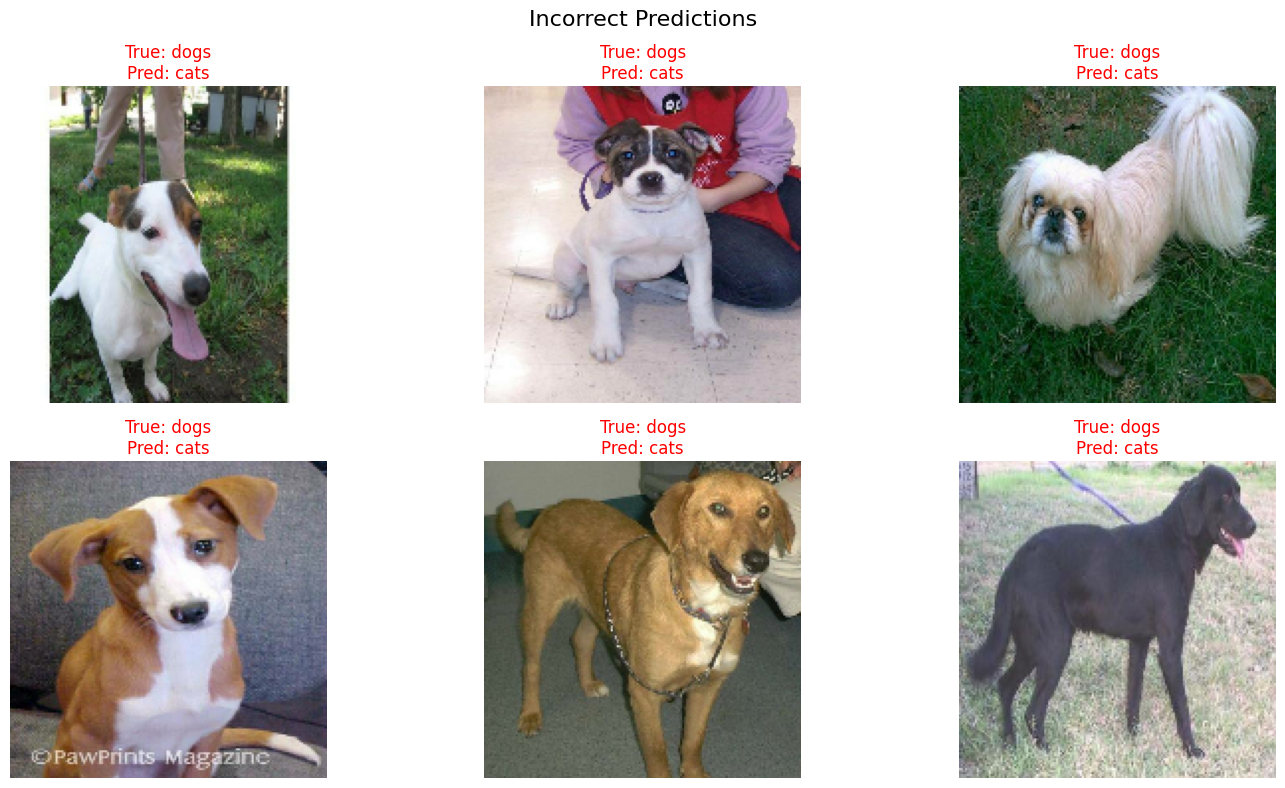

In [ ]:
show_images(image_batch, label_batch.numpy().astype(int), pred_labels, correct=False)

## Target Overfitting

In [ ]:
# Freeze all but last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add Dropout to prevent overfitting
from tensorflow.keras.layers import Dropout

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile with lower LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
new_history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.5564 - loss: 0.7079 - val_accuracy: 0.5750 - val_loss: 0.6802
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5680 - loss: 0.7017 - val_accuracy: 0.5910 - val_loss: 0.6732
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5855 - loss: 0.6818 - val_accuracy: 0.6030 - val_loss: 0.6670
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.6082 - loss: 0.6622 - val_accuracy: 0.6060 - val_loss: 0.6615
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6149 - loss: 0.6563 - val_accuracy: 0.6150 - val_loss: 0.6563
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6279 - loss: 0.6429 - val_accuracy: 0.6210 - val_loss: 0.6516
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6186 - loss: 0.6490 - val_accuracy: 0.6250 - val_loss: 0.6471
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6357 - loss: 0.6336 - val_accuracy: 0.6300 - v